# Part 1. Collecting data and generating the hydrograph

I got the solutions for Part 1 from the Google Colab notebook which we used initially for artificial streamflow generation.

## a) Hydrograph of daily discharges

In [ ]:
!pip install climata

# This code snippet collects streamflow data from the USGS database using
# the python climata library
import numpy as np
import pandas as pd
from climata.usgs import DailyValueIO
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

# set parameters
station_id = "01576000" # Marietta gaging station id
param_id = "00060" # discharge in cubic feet per second/ day
start_date = '1/01/1932'
end_date = '31/12/2001'
datelist = pd.date_range(start=start_date, end=end_date)

data = DailyValueIO(
    start_date=datelist[0],
    end_date=datelist[-1],
    station=station_id,
    parameter=param_id,
)

#retrieve the flow and date values from data
for series in data:
  flow = [r[1] for r in series.data]
  dates = [r[0] for r in series.data]

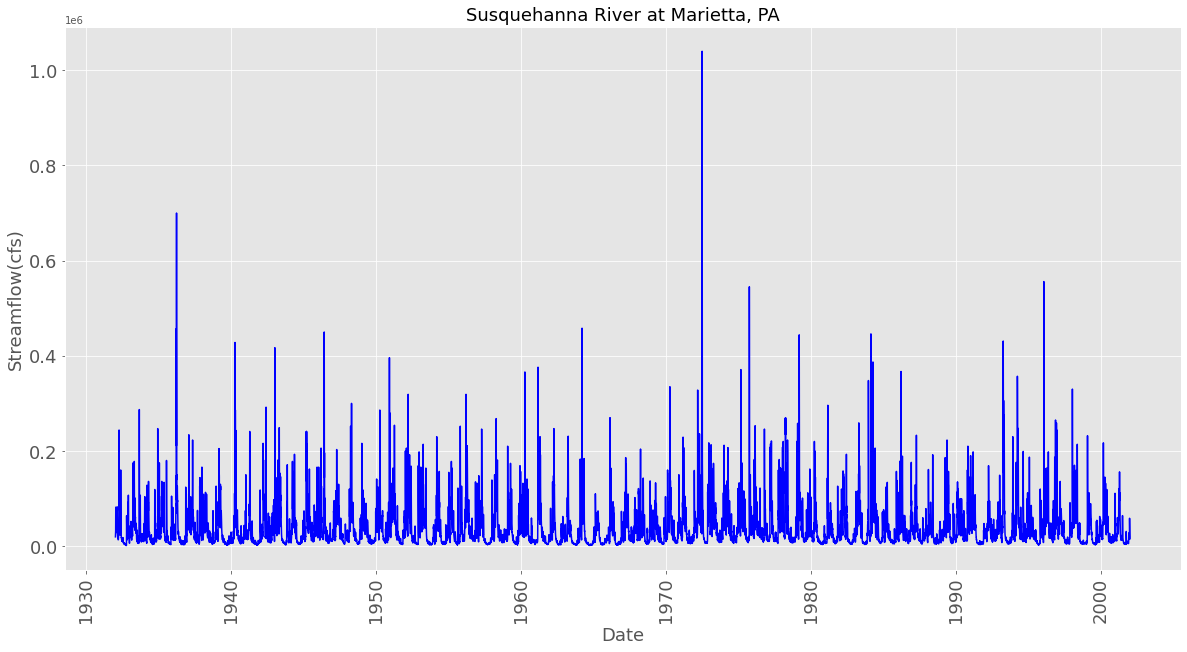

In [ ]:
plt.plot(dates, flow, color='blue')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Streamflow(cfs)', fontsize=18)
plt.title(series.site_name, fontsize=18)
plt.xticks(rotation='vertical', fontsize=18)
plt.yticks(fontsize=18)
plt.show()

## b) Min, mean, max of each month across years

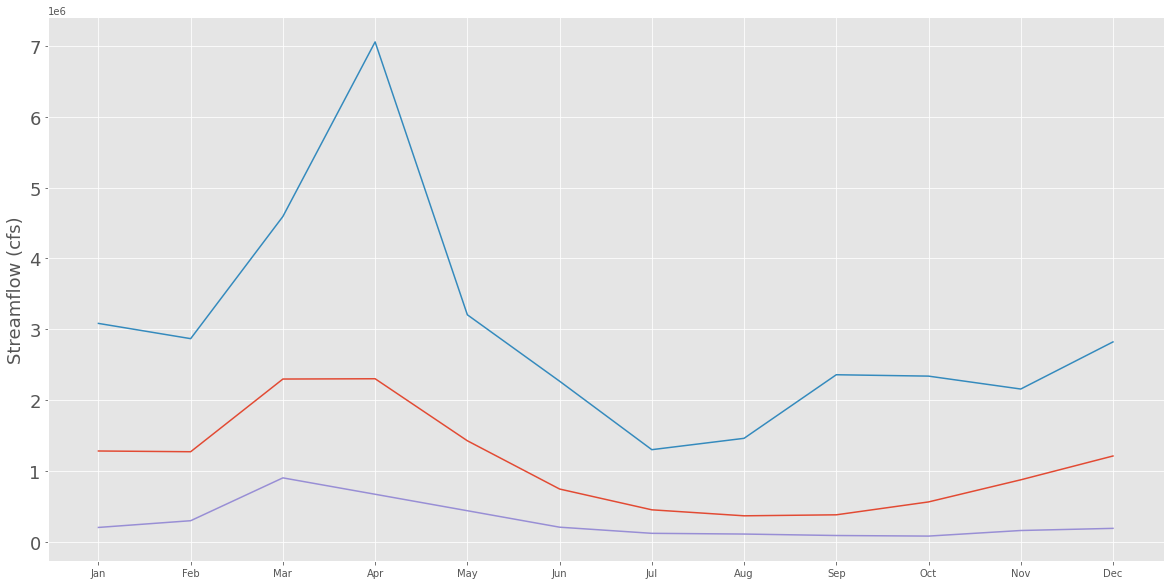

In [ ]:
idx_no_leap_years = [np.where(datelist.is_leap_year == False)][0][0]
flow_no_leap_years = [flow[date] for date in idx_no_leap_years]
dates_no_leap_years = [dates[date] for date in idx_no_leap_years]

n_years = int(len(flow_no_leap_years)/365)
n_months = 12
days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
monthly_flow = []
year_stamp = []
for year in range(n_years):
  start = year * 365
  month = 0
  while month < n_months:
    finish = int(start + days_per_month[month])
    year_stamp.append(dates_no_leap_years[finish-1].year)
    monthly_flow.append(np.sum(flow_no_leap_years[start:finish]))
    start += days_per_month[month]
    month += 1

n_years = len(monthly_flow)//12
monthly_flows_reshaped = np.reshape(monthly_flow, (n_years, 12)).T
monthly_flows_mean=np.mean(monthly_flows_reshaped, axis=1)
monthly_flows_min=np.min(monthly_flows_reshaped, axis=1)
monthly_flows_max=np.max(monthly_flows_reshaped, axis=1)

plt.plot(monthly_flows_mean)
plt.plot(monthly_flows_max)
plt.plot(monthly_flows_min)
plt.ylabel('Streamflow (cfs)', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(ticks=range(12), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()


## c) Wettest and driest years

In [ ]:
# Let's store the total of each year in a dictionary (year in the key, total discharge in the value)
year_and_total = dict()
for year in range(n_years):
  start = year * 12
  year_total = np.sum(monthly_flow[start:start+12])
  year_and_total[year_stamp[start+1]] = year_total

In [ ]:
driest_year = list(dict(sorted(year_and_total.items(), key=lambda item: item[1])).keys())[0]
wettest_year = list(dict(sorted(year_and_total.items(), key=lambda item: item[1])).keys())[-1]

In [ ]:
driest_year

1965

In [ ]:
wettest_year

1945

**NOTE**: Although it seems to be a very wet year visually, probably I'm skipping 1972 because it is a leap year. Next time, do the aggregation on the daily values instead of leap year dropped monthly flows.

# Part 2. Quantifying droughts

I don't want to lose the leap years in this analysis. Therefore, I will re-aggregate daily values to monthly by **averaging** within a month instead of summing up. This will produce streamflow values expressed in terms of **cfs per month**.

In [ ]:
n_years = int(len(flow)/365) # Not dropping any leap years
n_months = 12
days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
monthly_flow_average = []
year_stamp_average = []
for year in range(n_years):
  start = year * 365
  month = 0
  while month < n_months:
    finish = int(start + days_per_month[month])
    year_stamp_average.append(dates[finish-1].year)
    monthly_flow_average.append(np.mean(flow[start:finish]))
    start += days_per_month[month]
    month += 1

Y_t = np.log(monthly_flow_average)
mu = np.mean(Y_t)
std = np.std(Y_t)
Z_t =(Y_t-mu)/std


In [ ]:
len(monthly_flow_average)

840

In [ ]:
# Reduce dates to year and month only:
initial_year = dates[0].year
last_year = dates[-1].year
months = range(1,13)

reduced_dates = []
for i in dates:
  if not any(map(lambda x: (x.year, x.month) == (i.year, i.month), reduced_dates)):
    reduced_dates.append(i)

In [ ]:
def findDroughts(normalized_log_streamflow):

  total_observations = len(normalized_log_streamflow)
  # first calculate the moving averages of 6 observations:

  numbers_series = pd.Series(normalized_log_streamflow)
  windows = numbers_series.rolling(6)
  moving_averages = windows.mean()
  # first 5 months will be NaN due to our window being 6, replace them with 0:
  moving_averages_list = moving_averages.fillna(0).tolist()

  # Now that we have the moving averages, let's apply the drought criterion:
  drought_period_indices = []

  for i in range(6, total_observations):
    section_of_six = moving_averages_list[i-6:i]
    if all(map(lambda x: x<0, section_of_six)) and any(map(lambda x: x<-1, section_of_six)):
      drought_period_indices.append(i)

  plt.plot(reduced_dates, moving_averages_list, color='black')
  plt.vlines(x = [reduced_dates[x] for x in drought_period_indices], ymin=-2,
             ymax = 2, colors = 'red')
  plt.xlabel('Date',fontsize=18)
  plt.ylabel('SSI$_6$', fontsize=18)
  plt.title("Drought investigation SSI6 criterion", fontsize=18)
  #plt.xticks(rotation='vertical', fontsize=18)
  plt.yticks(fontsize=18)
  plt.show()

  return drought_period_indices



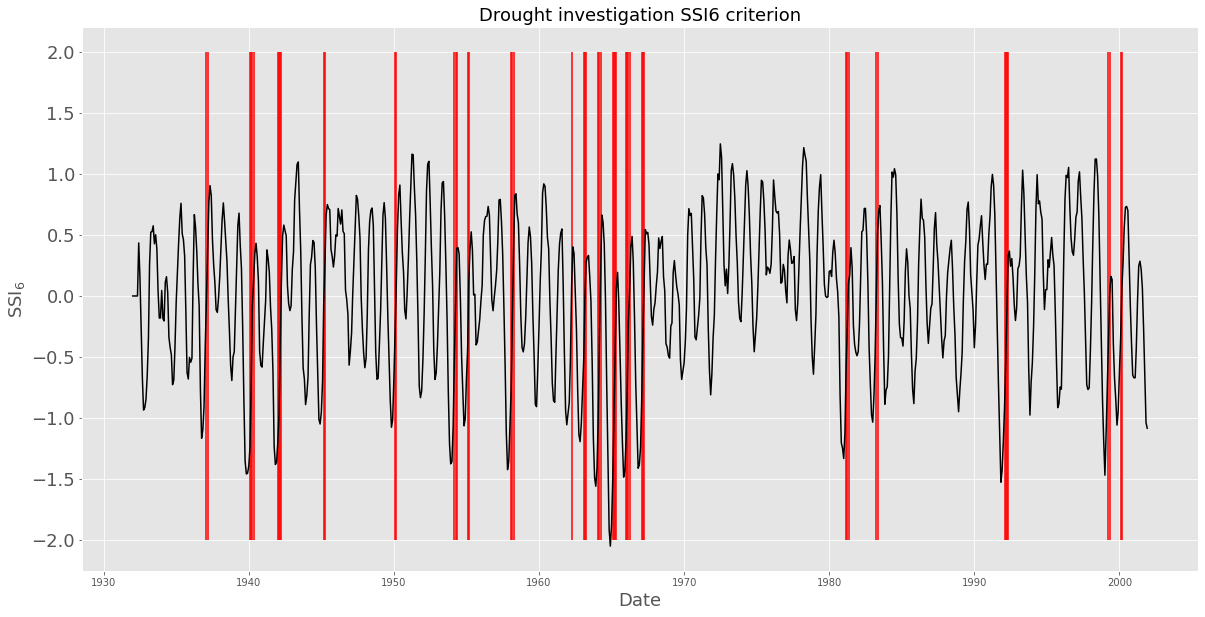

In [ ]:
drought_indices = findDroughts(Z_t)

# Part 3. Visualizing streamflow variability

In [ ]:
len(monthly_flow_average)

840

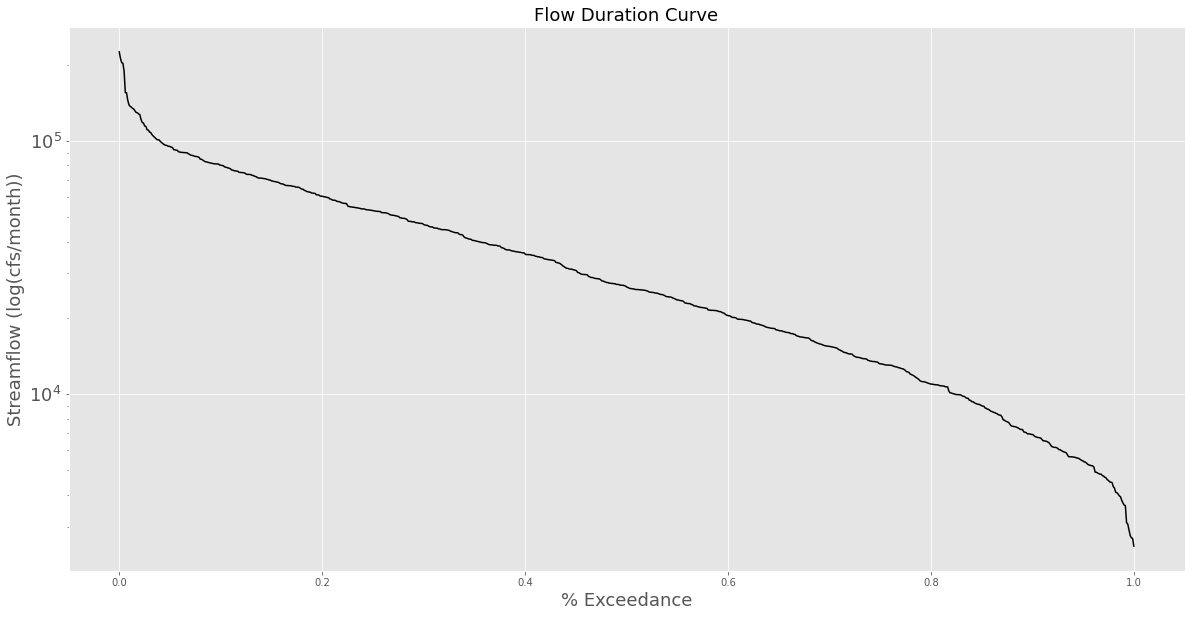

In [ ]:
plt.semilogy(np.linspace(0,1,num = len(monthly_flow_average)),
          sorted(monthly_flow_average, reverse=True), color='black')
plt.xlabel('% Exceedance',fontsize=18)
plt.ylabel('Streamflow (log(cfs/month))', fontsize=18)
plt.title("Flow Duration Curve", fontsize=18)
#plt.xticks(rotation='vertical', fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# Part 4. Synthetic streamflow generation

In [ ]:
def cholesky_extended(input_matrix):
  from scipy.linalg import cholesky, eig
  try:
    output = cholesky(input_matrix)
  except:
    k = min(min(np.real(eig(input_matrix)[0])), -1 * np.spacing(1))
    input_matrix = input_matrix - k * np.identity(np.shape(input_matrix)[0])
    input_matrix = input_matrix / input_matrix[0,0]
    output = cholesky_extended(input_matrix)

  return output

def monthly_generator(historical_monthly_series, synthetic_years, mean_adjustment=1, sd_adjustment=1):
  # This function receives the historical monthly series as an iterable (list,
  # 1D np.array) and the number of years for which synthetic monthly streamflow
  # data is to be generated

  # Since a shifting of the synthetic flows is needed to not miss year-to-year
  # correlation, we should start by increasing the synthetic years by one to end
  # up with the desired number of years
  synthetic_years += 1

  # First convert the historical data into a 2D matrix where rows correspond to
  # years and each column is a month (0-January, 11-December):
  hist_years = int(len(historical_monthly_series) / 12) # Nr of years in input
  historical_matrix = np.reshape(historical_monthly_series, (hist_years, 12))

  # Following the method described by Quinn, we sample integers for each cell in
  # our (prospective) synthetic data. This part is needed to preserve spatial
  # correlation i.e. to draw the same historical year's observation for each of
  # the spatially correlated sites:
  random_int_matrix = np.random.randint(
      low=0, high=hist_years, size=(synthetic_years,12)
    )

  # Making a log transform due to the log-normal distribution assumption for
  # streamflows:
  log_historical = np.log(historical_matrix)

  # Mean and std parameters of each month's distribution:
  monthly_mean_vector = np.mean(log_historical, axis=0)
  monthly_std_vector = np.std(log_historical, axis=0)

  # Standardization of the historical logged matrix to standard normal
  # distribution (Z(0,1)):
  Z_historical = (log_historical - monthly_mean_vector) / monthly_std_vector

  # We get another (shifted) version of this Z matrix for year-to-year
  # correlation. Get rid of first and last 6 months of the dataset:
  Z_shifted = np.reshape(((np.ndarray.flatten(Z_historical))[6:-6]), (-1,12))

  # For temporal correlation adjustment, calculate upper cholesky matrices:
  U_cholesky = cholesky_extended(np.corrcoef(Z_historical, rowvar=False))
  U_cholesky_shifted = cholesky_extended(np.corrcoef(Z_shifted, rowvar=False))

  # Now we generate our synthetic Z by adhering to the random_int_matrix:
  uncorr_synthetic = np.zeros(shape=(synthetic_years,12))
  for year in range(synthetic_years):
    for month in range(12):
      uncorr_synthetic[year, month] = Z_historical[
          random_int_matrix[year, month], month
        ]
  # Get the shifted version as usual:
  uncorr_shifted = np.reshape(
      ((np.ndarray.flatten(uncorr_synthetic))[6:-6]), (-1,12)
    )

  # Matrix multiplication with the upper triangular matrix from Cholesky
  # decomposition gives the correlated matrices:
  corr_Z_synthetic = np.matmul(uncorr_synthetic, U_cholesky)
  corr_Z_shifted = np.matmul(uncorr_shifted, U_cholesky_shifted)

  # Concatenating the last 6 columns of the shifted matrix (January to June)
  # starting from row 1 with the last 6 months of the original matrix (July to
  # December) starting from row 2 gives the fully correlated final version:
  final_log = np.concatenate(
      (corr_Z_shifted[:,6:], corr_Z_synthetic[1:,6:]), axis=1
    )

  # Before backtransforming the log-normal series into their true scale, do mean and sd
  # adjustments if there is any. If both are set to 1, below functions do not change their
  # values at all
  common_ln_term = np.log( (sd_adjustment/mean_adjustment)**2 * (np.exp(np.power(monthly_std_vector, 2)) - 1) + 1)
  monthly_mean_vector = np.log(mean_adjustment) + monthly_mean_vector + (np.power(monthly_std_vector, 2) * 0.5) - 0.5 * common_ln_term
  monthly_std_vector = np.sqrt(common_ln_term)

  # Back transform the log-normal standardized flow values:
  print(np.shape(monthly_std_vector))
  print(monthly_mean_vector)
  generated_matrix = np.exp(
      (final_log * monthly_std_vector) + monthly_mean_vector
    )
  flat_streamflows = list(np.ndarray.flatten(generated_matrix))
  return flat_streamflows, monthly_std_vector, monthly_mean_vector


In [ ]:
synthetic_years, std, mean = monthly_generator(monthly_flow, 100)

(12,)
[13.88448369 13.94344103 14.57599279 14.56346737 14.05441262 13.37967602
 12.87374178 12.63721723 12.56607858 12.90175901 13.46478604 13.84643731]


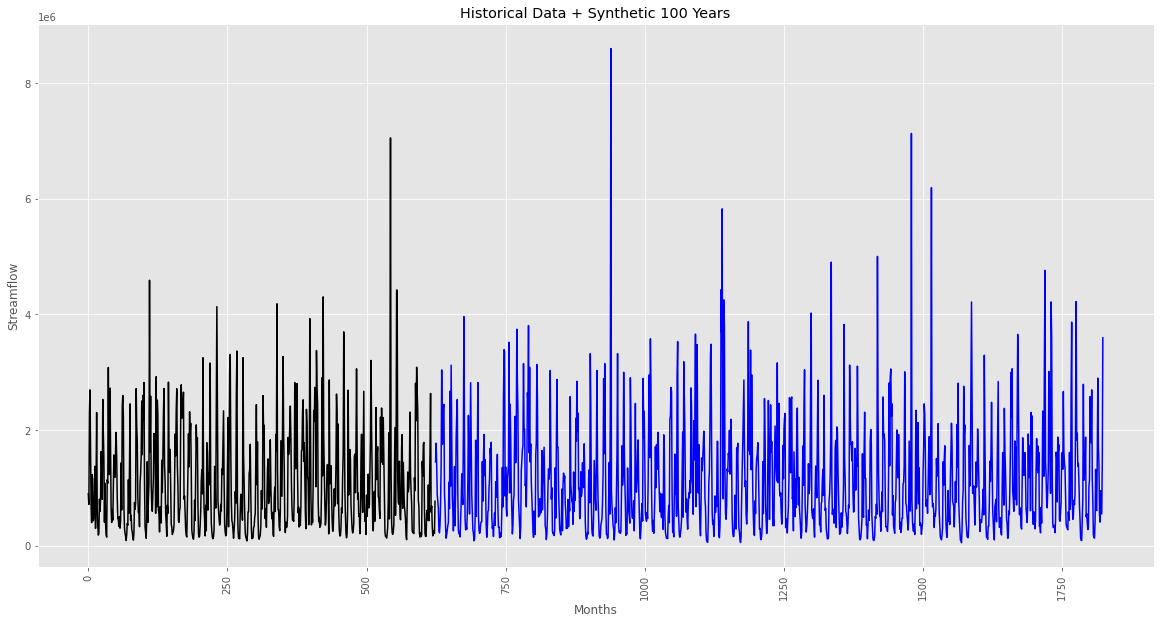

In [ ]:
plt.plot(range(len(monthly_flow), len(monthly_flow) + len(synthetic_years)),
         synthetic_years, color='blue')
plt.plot(monthly_flow, color='k')
plt.xlabel('Months')
plt.ylabel('Streamflow')
plt.title("Historical Data + Synthetic 100 Years")
plt.xticks(rotation='vertical')
plt.show()